In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import glob

In [2]:
# Initialize MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

In [3]:
def extract_landmarks_from_image(image_path):
    """Extract hand landmarks from an image file using MediaPipe"""
    try:
        # Read image and convert to RGB
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not read image {image_path}")
            return None
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process with MediaPipe
        results = hands.process(image_rgb)
        
        # Extract landmarks if hands are detected
        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]  # Get the first hand
            landmarks = []
            for landmark in hand_landmarks.landmark:
                landmarks.append([landmark.x, landmark.y, landmark.z])
            return np.array(landmarks).flatten()  # Flatten to 1D array
        else:
            print(f"Warning: No hand detected in {image_path}")
            return None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None
    



In [10]:
def process_dataset(dataset_path):
    """Process all images in the dataset structure and extract hand landmarks"""
    all_data = []
    all_labels = []
    
    # Assuming the dataset is structured with each gesture in its own folder
    # e.g., dataset/thumbs_up/, dataset/peace_sign/, etc.
    
    gesture_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    print(f"Found {len(gesture_folders)} gesture classes: {gesture_folders}")
    
    for gesture in gesture_folders:
        gesture_path = os.path.join(dataset_path, gesture)
        print(f"Processing gesture: {gesture}")
        
        # Get all image files in the gesture folder (case-insensitive)
        image_files = []
        for file in os.listdir(gesture_path):
            file_path = os.path.join(gesture_path, file)
            if os.path.isfile(file_path):
                file_ext = os.path.splitext(file)[1].lower()
                if file_ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                    image_files.append(file_path)
        
        print(f"  Found {len(image_files)} images")
        
        processed_count = 0
        for image_path in image_files:
            landmarks = extract_landmarks_from_image(image_path)
            if landmarks is not None:
                all_data.append(landmarks)
                all_labels.append(gesture)
                processed_count += 1
        
        print(f"  Successfully processed {processed_count} images with detected hands")
    
    print(f"Total processed samples: {len(all_data)} across {len(set(all_labels))} gestures")
    return np.array(all_data), all_labels

# Process the dataset
X, y = process_dataset("dataset")

Found 26 gesture classes: ['A', 'agree', 'answer', 'are you', 'congratulations', 'family', 'good morning', 'happy birthday', 'hello', 'help', 'home', 'how are you', 'ily', 'meet', 'no', 'please', 'problem', 'seat', 'sick', 'thankyou', 'thirsty', 'together', 'understand', 'wait', 'where', 'yes']
Processing gesture: A
  Found 2 images
  Successfully processed 2 images with detected hands
Processing gesture: agree
  Found 10 images
  Successfully processed 10 images with detected hands
Processing gesture: answer
  Found 10 images
  Successfully processed 10 images with detected hands
Processing gesture: are you
  Found 0 images
  Successfully processed 0 images with detected hands
Processing gesture: congratulations
  Found 40 images
  Successfully processed 39 images with detected hands
Processing gesture: family
  Found 10 images
  Successfully processed 10 images with detected hands
Processing gesture: good morning
  Found 40 images
  Successfully processed 39 images with detected hand

In [11]:
def train_model(X, y):
    """Train a model on the extracted landmarks"""
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Save label encoder mapping
    label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
    with open('gesture_mapping.json', 'w') as f:
        json.dump(label_mapping, f)
    print(f"Label mapping: {label_mapping}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    # Define model
    input_shape = X_train.shape[1]  # Number of features (21 landmarks * 3 coordinates = 63)
    num_classes = len(set(y_encoded))
    
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=250,
        batch_size=32,
        verbose=1
    )
    
    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {accuracy:.4f}")
    
    # Save model
    model.save('gesture_model.h5')
    print("Model saved as 'gesture_model.h5'")
    
    return model, label_mapping, history

# Train the model using the already processed data
if len(X) > 0:
    model, label_mapping, history = train_model(X, y)
else:
    print("No valid hand landmarks extracted from dataset images.")

Label mapping: {0: 'A', 1: 'agree', 2: 'answer', 3: 'congratulations', 4: 'family', 5: 'good morning', 6: 'happy birthday', 7: 'hello', 8: 'help', 9: 'home', 10: 'how are you', 11: 'ily', 12: 'meet', 13: 'no', 14: 'please', 15: 'problem', 16: 'seat', 17: 'sick', 18: 'thankyou', 19: 'thirsty', 20: 'together', 21: 'understand', 22: 'wait', 23: 'where', 24: 'yes'}
Training model...


C:\Users\meetv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0785 - loss: 3.1947 - val_accuracy: 0.1151 - val_loss: 3.0667
Epoch 2/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0977 - loss: 3.0215 - val_accuracy: 0.1151 - val_loss: 3.0084
Epoch 3/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1093 - loss: 2.9395 - val_accuracy: 0.1799 - val_loss: 2.9461
Epoch 4/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1364 - loss: 2.8549 - val_accuracy: 0.1151 - val_loss: 2.8564
Epoch 5/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1654 - loss: 2.8029 - val_accuracy: 0.2230 - val_loss: 2.7678
Epoch 6/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2040 - loss: 2.7038 - val_accuracy: 0.2806 - val_loss: 2.6656
Epoch 7/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2793 - loss: 2.5470 - val_accuracy: 0.3813 - val_loss: 2.5150
Epoch 8/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3077 - loss: 2.4602 - val_accuracy: 0.

Test accuracy: 0.9065
Model saved as 'gesture_model.h5'


Generating predictions...


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Creating confusion matrix...

Classification Report:
                 precision    recall  f1-score   support

              A       0.50      0.50      0.50         2
          agree       1.00      1.00      1.00        10
         answer       1.00      1.00      1.00        10
congratulations       0.90      0.97      0.94        39
         family       0.91      1.00      0.95        10
   good morning       1.00      0.97      0.99        39
 happy birthday       1.00      1.00      1.00        40
          hello       1.00      0.80      0.89        10
           help       0.80      0.73      0.76        11
           home       1.00      1.00      1.00        38
    how are you       1.00      0.97      0.99        40
            ily       1.00      0.67      0.80         9
           meet       1.00      1.00      1.00        40
             no       0.67      0.57      0.62         7
         please       0.98      0.98      0.98      

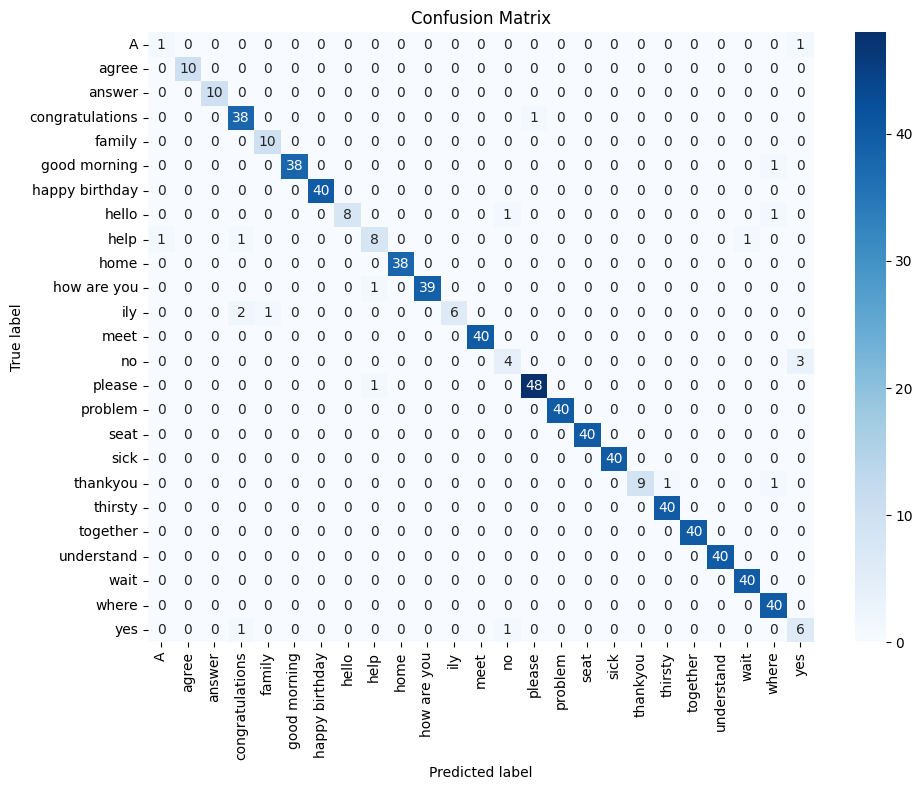

In [12]:
# Add these imports at the top of your file
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Add this function to generate and display the confusion matrix
def generate_confusion_matrix(X, y_true_labels, model, label_mapping):
    """Generate and visualize confusion matrix from the trained model"""
    
    if len(X) == 0:
        print("No valid hand landmarks available.")
        return
    
    # Convert string labels to numeric using the same mapping as during training
    label_encoder = LabelEncoder()
    # First fit the encoder with all possible classes from our mapping
    all_classes = [label_mapping[i] for i in range(len(label_mapping))]
    label_encoder.fit(all_classes)
    # Now transform our true labels
    y_true = label_encoder.transform(y_true_labels)
    
    # Make predictions
    print("Generating predictions...")
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Generate confusion matrix
    print("Creating confusion matrix...")
    cm = confusion_matrix(y_true, y_pred)
    
    # Generate classification report
    class_names = [label_mapping[i] for i in range(len(label_mapping))]
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("\nClassification Report:")
    print(report)
    
    # Save report to file
    with open('classification_report.txt', 'w') as f:
        f.write(report)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    # Save confusion matrix image
    plt.savefig('confusion_matrix.png')
    print("Confusion matrix saved as 'confusion_matrix.png'")
    
    try:
        plt.show()
    except Exception as e:
        print(f"Could not display plot: {e}")
        print("Confusion matrix image has been saved to 'confusion_matrix.png'")

# Generate confusion matrix using already processed data and trained model
if len(X) > 0 and 'model' in locals() and 'label_mapping' in locals():
    generate_confusion_matrix(X, y, model, label_mapping)
else:
    print("Make sure you have run the training code first to have X, y, model, and label_mapping available.")

In [13]:
def predict_from_image(image_path):
    """Use the trained model to predict gesture from a single image"""
    # Load model and label mapping
    try:
        model = keras.models.load_model('gesture_model.h5')
        with open('gesture_mapping.json', 'r') as f:
            label_mapping = json.load(f)
    except FileNotFoundError:
        print("Model or mapping file not found. Please train the model first.")
        return
    
    # Extract landmarks from the image
    landmarks = extract_landmarks_from_image(image_path)
    if landmarks is None:
        print(f"No hand detected in {image_path}")
        return
    
    # Make prediction
    prediction = model.predict(np.array([landmarks]), verbose=0)
    gesture_id = np.argmax(prediction[0])
    gesture_name = label_mapping[str(gesture_id)]
    confidence = prediction[0][gesture_id]
    
    print(f"Predicted gesture: {gesture_name}")
    print(f"Confidence: {confidence:.2f}")
    
    # Display the image with prediction
    try:
        image = cv2.imread(image_path)
        cv2.putText(image, f"Gesture: {gesture_name}", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(image, f"Confidence: {confidence:.2f}", (10, 70), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        cv2.imshow('Predicted Gesture', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    except Exception as e:
        print(f"Error displaying image: {e}")


predict_from_image("test/2thank_you.png")
predict_from_image("test/family8.jpeg")
predict_from_image("test/hello3.jpg")
predict_from_image("test/help4.jpeg")
predict_from_image("test/yes3.jpeg")
predict_from_image("test/no4.jpeg")
predict_from_image("test/ily2.jpg")
predict_from_image("test/please2.jpeg")
predict_from_image("test/thankyou_1.png")

Predicted gesture: thankyou
Confidence: 0.50


Predicted gesture: family
Confidence: 0.70


Predicted gesture: hello
Confidence: 0.73


Predicted gesture: wait
Confidence: 0.94


Predicted gesture: no
Confidence: 0.32


Predicted gesture: yes
Confidence: 0.48


Predicted gesture: congratulations
Confidence: 0.27


Predicted gesture: please
Confidence: 0.71


Predicted gesture: thirsty
Confidence: 0.96


In [14]:
def batch_predict(test_folder): 
    """Predict gestures for all images in a test folder"""
    # Load model and label mapping
    try:
        model = keras.models.load_model('gesture_model.h5')
        with open('gesture_mapping.json', 'r') as f:
            label_mapping = json.load(f)
    except FileNotFoundError:
        print("Model or mapping file not found. Please train the model first.")
        return
    
    # Get all image files in the test folder
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = []
    for ext in valid_extensions:
        image_files.extend(glob.glob(os.path.join(test_folder, f"*{ext}")))
        image_files.extend(glob.glob(os.path.join(test_folder, f"*{ext.upper()}")))
    
    print(f"Found {len(image_files)} test images")
    
    results = []
    for image_path in image_files:
        # Extract landmarks from the image
        landmarks = extract_landmarks_from_image(image_path)
        if landmarks is None:
            print(f"No hand detected in {image_path}")
            results.append((image_path, "No hand detected", 0.0))
            continue
        
        # Make prediction
        prediction = model.predict(np.array([landmarks]), verbose=0)
        gesture_id = np.argmax(prediction[0])
        gesture_name = label_mapping[str(gesture_id)]
        confidence = float(prediction[0][gesture_id])
        
        results.append((image_path, gesture_name, confidence))
        print(f"{os.path.basename(image_path)}: {gesture_name} ({confidence:.2f})")
    
    # Save results to CSV
    with open('prediction_results.csv', 'w') as f:
        f.write("image_path,predicted_gesture,confidence\n")
        for image_path, gesture, confidence in results:
            f.write(f"{image_path},{gesture},{confidence}\n")
    
    print(f"Results saved to prediction_results.csv")

batch_predict("test")


Found 22 test images
A.jpg: seat (0.98)
hello3.jpg: hello (0.73)
ily2.jpg: congratulations (0.27)
A.jpg: seat (0.98)
hello3.jpg: hello (0.73)
ily2.jpg: congratulations (0.27)
family8.jpeg: family (0.70)
help4.jpeg: wait (0.94)
house3.jpeg: thirsty (0.91)
no4.jpeg: yes (0.48)
please2.jpeg: please (0.71)
yes3.jpeg: no (0.32)
family8.jpeg: family (0.70)
help4.jpeg: wait (0.94)
house3.jpeg: thirsty (0.91)
no4.jpeg: yes (0.48)
please2.jpeg: please (0.71)
yes3.jpeg: no (0.32)
2thank_you.png: thankyou (0.50)
thankyou_1.png: thirsty (0.96)
2thank_you.png: thankyou (0.50)
thankyou_1.png: thirsty (0.96)
Results saved to prediction_results.csv
